# User Defined Rebound Collision Resolutions
In the [CloseEncounter](https://rebound.readthedocs.io/en/latest/ipython/CloseEncounters.html) example, we discuss methods for resolving collisions in REBOUND through exceptions and the use of the `sim.collision_resolve = "merge"` method.

Using the same 3-Body setup, let us explore how to define and implement the same collision resolution function in python and pass it to the `sim.collision_resolve` function pointer.

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

def setupSimulation():
    ''' Setup the 3-Body scenario'''
    sim = rebound.Simulation()
    sim.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    sim.add(m=1.)
    sim.add(m=1e-3, a=1., r=np.sqrt(1e-3/3.)) # we now set collision radii!
    sim.add(m=5e-3, a=1.25, r=1.25*np.sqrt(5e-3/3.))
    sim.move_to_com()
    return sim

To reitterate the previous method, let's run the built-in `merge` collision resolution method

In [2]:
sim = setupSimulation()
sim.collision = "direct"
sim.collision_resolve = "merge" # Built in function

print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))
sim.integrate(100.)
print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))

Particles in the simulation at t=   0.0: 3
System Mass: [1.0, 0.001, 0.005]
Particles in the simulation at t= 100.0: 2
System Mass: [1.0, 0.006]


We can see above that two particles merged into one with a combined mass of 0.006.

Let's now try to impliment this collision function ourselves!

To do this, we need to write a function which we can pass to `sim.collision_resolve`. In this case let's define `my_merge`. 

Now, whenever a collision occours, REBOUND will pass our function two parameters:
 - `sim_pointer`: a pointer to the simulation object which the collision occured in. (Because it is a ctypes pointer, you will need to use the `.contents` attribute to access the simulation object)
 - `collision`: this structure contains the attributes .p1 and .p2 which are the indicies of the two particles involved in the collision

Using these inputs, we can define the necessary logic to handle the collision. The return value of our function determines how REBOUND proceeds afterwards:

 - 0: Simulation continues without changes
 - 1: remove p1 from simulation
 - 2: remove p2 from simulation

Let us look at how this information can be used to impliment the logic of the a `merge` method for colliding particles in a totally inelastic collision.

In [3]:
def my_merge(sim_pointer, collided_particles_index):

    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.    
    j = collided_particles_index.p2 

    # This part is exciting! We can execute additional code during collisions now!
    fig, ax = rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
    ax.set_title("Merging particle {} into {}".format(j, i))
    ax.text(ps[1].x, ps[1].y, "1"); 
    ax.text(ps[2].x, ps[2].y, "2")
    # So we plot the scenario exactly at the timestep that the collision function is triggered

    # Merging Logic 
    total_mass = ps[i].m + ps[j].m
    merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass # conservation of momentum

    # merged radius assuming a uniform density
    merged_radius = (ps[i].r**3 + ps[j].r**3)**(1/3)

    ps[i] = merged_planet   # update p1's state vector (mass and radius will need corrections)
    ps[i].m = total_mass    # update to total mass
    ps[i].r = merged_radius # update to joined radius

    return 2 # remove particle with index j

Now we can set our new collision resolution function in the simulation object.

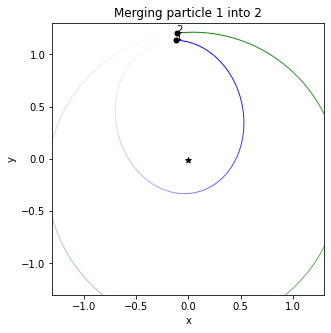

In [4]:
sim = setupSimulation()
sim.collision = "direct"
ps = sim.particles
sim.collision_resolve = my_merge # user defined collision resolution function
sim.integrate(100.)

Not that we were not only able to resolve the collision, but also to run additional code during the collision, in this case to make a plot, which can be very useful for debugging or logging. Now that you know the basics, you can expand the scenario here and resolve collisions according to the astrophysical problem you are working on.